<a href="https://colab.research.google.com/github/fantastic-jpn/monday-4th-report/blob/main/Monday_4th_report_1st_2nd_3rd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
!git --version


git version 2.34.1


In [2]:
!git clone https://github.com/PacktPublishing/Hands-On-Genetic-Algorithms-with-Python.git

Cloning into 'Hands-On-Genetic-Algorithms-with-Python'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 246 (delta 23), reused 17 (delta 17), pack-reused 213 (from 1)
Receiving objects: 100% (246/246), 175.99 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [3]:
!git clone https://github.com/ryanjoneil/tsplib.git

Cloning into 'tsplib'...
remote: Enumerating objects: 269, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 269 (delta 34), reused 269 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (269/269), 3.01 MiB | 3.38 MiB/s, done.
Resolving deltas: 100% (34/34), done.


# Initialize tsp.py and check how it runs

In [4]:
#we will use eil51 /content/tsplib/elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/eil51.tsp

import csv
import pickle
import os

import numpy as np

import matplotlib.pyplot as plt

In [5]:
class TravelingSalesmanProblem:
    """This class encapsulates the Traveling Salesman Problem.
    City coordinates are read from an online file and distance matrix is calculated.
    The data is serialized to disk.
    The total distance can be calculated for a path represented by a list of city indices.
    A plot can be created for a path represented by a list of city indices.

    :param name: The name of the corresponding TSPLIB problem, e.g. 'burma14' or 'bayg29'.
    """

    def __init__(self, name):
        """
        Creates an instance of a TSP

        :param name: name of the TSP problem
        """

        # initialize instance variables:
        self.name = name
        self.locations = []
        self.distances = []
        self.tspSize = 0

        # initialize the data:
        self.__initData()

    def __len__(self):
        """
        returns the length of the underlying TSP
        :return: the length of the underlying TSP (number of cities)
        """
        return self.tspSize

    def __initData(self):
        """Reads the serialized data, and if not available - calls __create_data() to prepare it
        """

        # attempt to read serialized data:
        try:
            self.locations = pickle.load(open(os.path.join("tsp-data", self.name + "-loc.pickle"), "rb"))
            self.distances = pickle.load(open(os.path.join("tsp-data", self.name + "-dist.pickle"), "rb"))
        except (OSError, IOError):
            pass

        # serailized data not found - create the data from scratch:
        if not self.locations or not self.distances:
            self.__createData()

        # set the problem 'size':
        self.tspSize = len(self.locations)

    def __createData(self):
        """Reads the desired TSP file from the Internet, extracts the city coordinates, calculates the distances
        between every two cities and uses them to populate a distance matrix (two-dimensional array).
        It then serializes the city locations and the calculated distances to disk using the pickle utility.
        """
        self.locations = []

        # open whitespace-delimited file from url and read lines from it:
        with open("/content/tsplib/elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/" + self.name + ".tsp") as f:
            reader = csv.reader(f, delimiter=" ", skipinitialspace=True)

            # skip lines until one of these lines is found:
            for row in reader:
                if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                    break

            # read data lines until 'EOF' found:
            for row in reader:
                if row[0] != 'EOF':
                    # remove index at beginning of line:
                    del row[0]

                    # convert x,y coordinates to ndarray:
                    self.locations.append(np.asarray(row, dtype=np.float32))
                else:
                    break

            # set the problem 'size':
            self.tspSize = len(self.locations)

            # print data:
            print("length = {}, locations = {}".format(self.tspSize, self.locations))

            # initialize distance matrix by filling it with 0's:
            self.distances = [[0] * self.tspSize for _ in range(self.tspSize)]

            # populate the distance matrix with calculated distances:
            for i in range(self.tspSize):
                for j in range(i + 1, self.tspSize):
                    # calculate euclidean distance between two ndarrays:
                    distance = np.linalg.norm(self.locations[j] - self.locations[i])
                    self.distances[i][j] = distance
                    self.distances[j][i] = distance
                    print("{}, {}: location1 = {}, location2 = {} => distance = {}".format(i, j, self.locations[i], self.locations[j], distance))

            # serialize locations and distances:
            if not os.path.exists("tsp-data"):
                os.makedirs("tsp-data")
            pickle.dump(self.locations, open(os.path.join("tsp-data", self.name + "-loc.pickle"), "wb"))
            pickle.dump(self.distances, open(os.path.join("tsp-data", self.name + "-dist.pickle"), "wb"))

    def getTotalDistance(self, indices):
        """Calculates the total distance of the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: total distance of the path described by the given indices
        """
        # distance between th elast and first city:
        distance = self.distances[indices[-1]][indices[0]]

        # add the distance between each pair of consequtive cities:
        for i in range(len(indices) - 1):
            distance += self.distances[indices[i]][indices[i + 1]]

        return distance

    def plotData(self, indices):
        """plots the path described by the given indices of the cities

        :param indices: A list of ordered city indices describing the given path.
        :return: the resulting plot
        """

        # plot the dots representing the cities:
        plt.scatter(*zip(*self.locations), marker='.', color='red')

        # create a list of the corresponding city locations:
        locs = [self.locations[i] for i in indices]
        locs.append(locs[0])

        # plot a line between each pair of consequtive cities:
        plt.plot(*zip(*locs), linestyle='-', color='blue')

        return plt

length = 29, locations = [array([1150., 1760.], dtype=float32), array([ 630., 1660.], dtype=float32), array([  40., 2090.], dtype=float32), array([ 750., 1100.], dtype=float32), array([ 750., 2030.], dtype=float32), array([1030., 2070.], dtype=float32), array([1650.,  650.], dtype=float32), array([1490., 1630.], dtype=float32), array([ 790., 2260.], dtype=float32), array([ 710., 1310.], dtype=float32), array([840., 550.], dtype=float32), array([1170., 2300.], dtype=float32), array([ 970., 1340.], dtype=float32), array([510., 700.], dtype=float32), array([750., 900.], dtype=float32), array([1280., 1200.], dtype=float32), array([230., 590.], dtype=float32), array([460., 860.], dtype=float32), array([1040.,  950.], dtype=float32), array([ 590., 1390.], dtype=float32), array([ 830., 1770.], dtype=float32), array([490., 500.], dtype=float32), array([1840., 1240.], dtype=float32), array([1260., 1500.], dtype=float32), array([1280.,  790.], dtype=float32), array([ 490., 2130.], dtype=float32)

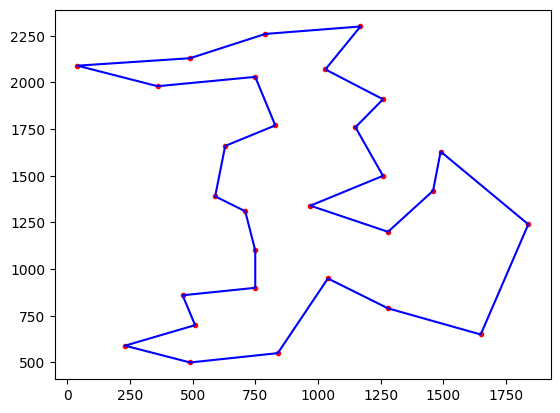

In [6]:
tsp = TravelingSalesmanProblem("bayg29")

# generate a random solution and evaluate it:
#randomSolution = random.sample(range(len(tsp)), len(tsp))

# see http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/bayg29.opt.tour
optimalSolution = [0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 7, 26, 15, 12, 23]

print("Problem name: " + tsp.name)
print("Optimal solution = ", optimalSolution)
print("Optimal distance = ", tsp.getTotalDistance(optimalSolution))

# plot the solution:
plot = tsp.plotData(optimalSolution)
plot.show()

# run solve_tsp.py for bayg29 and eil51

In [7]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import random
import array

import seaborn as sns

# define eaSimpleWithElitism() from elitism.py

In [8]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


# set up functions for genetic algorithm

In [84]:
# set the random seed for repeatable results
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# create the desired traveling salesman problem instace:
TSP_NAME = "eil51"  # name of problem
tsp = TravelingSalesmanProblem(TSP_NAME)

# Genetic Algorithm constants:
POPULATION_SIZE = 300
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 30
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.2   # probability for mutating an individual

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(tsp)), len(tsp))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [10]:
# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return tsp.getTotalDistance(individual),  # return a tuple


In [85]:
toolbox.register("evaluate", tpsDistance)


# Genetic operators:
toolbox.register("select",tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate",  tools.mutShuffleIndexes, indpb=1.0/len(tsp))


In [86]:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best individual info:
    best = hof.items[0]
    print("-- Best Ever Individual = ", best)
    print("-- Best Ever Fitness = ", best.fitness.values[0])

    # plot best solution:
    plt.figure(1)
    tsp.plotData(best)

    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')

    # show both plots:
    plt.show()

gen	nevals	min               	avg               
0  	300   	1334.3507080078125	1658.3470458984375
1  	249   	1334.3507080078125	1580.7183837890625
2  	248   	1291.0777587890625	1517.72998046875  
3  	245   	1249.15478515625  	1456.910400390625 
4  	244   	1249.15478515625  	1431.988525390625 
5  	251   	1237.29931640625  	1403.662109375    
6  	250   	1181.9119873046875	1369.426513671875 
7  	253   	1138.9842529296875	1347.8385009765625
8  	248   	1135.2518310546875	1321.1220703125   
9  	250   	1101.7674560546875	1287.8817138671875
10 	254   	1101.7674560546875	1277.9532470703125
11 	245   	1050.3543701171875	1248.7745361328125
12 	247   	1050.3543701171875	1230.6195068359375
13 	255   	1050.3543701171875	1211.79833984375  
14 	241   	1044.6270751953125	1200.6690673828125
15 	261   	1044.6270751953125	1192.927001953125 
16 	254   	975.376708984375  	1172.0286865234375
17 	257   	975.376708984375  	1161.560302734375 
18 	238   	975.376708984375  	1149.7818603515625
19 	243   	975.37670

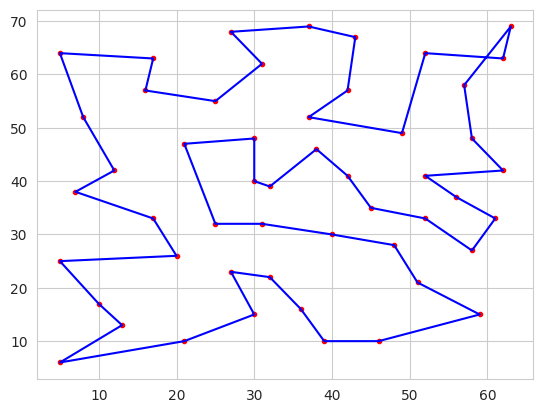

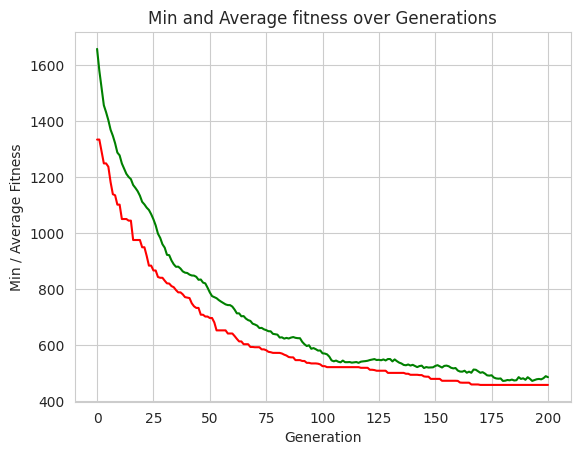

In [93]:
main()

# Implement own function

evolution flow is consisted of initialization, selection, crossover, mutation, evaluation, replacement.

In [14]:
tsp = TravelingSalesmanProblem("eil51")

print(len(tsp))
print(range(len(tsp))) # this is equal to array of 0 to 50

51
range(0, 51)


In [15]:

original = base.Toolbox()

#initialize individual and fitnessMin function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

#register population with Individual function
original.register("randomOrder", random.sample, range(len(tsp)), len(tsp))
original.register("individual", tools.initIterate, creator.Individual, original.randomOrder)
original.register("population", tools.initRepeat, list, original.individual)

population = original.population(n=POPULATION_SIZE)

print(population[0])
print(len(population))
print(type(population))

original.register("evaluate", tpsDistance)
# this is where we have to create our own function

def original_select_function(population, k):
  lowest_fitnesses = []
  pop_copy = population.copy()
  #this will select two lowest fitness individual as built-in function tools.selTournament()

  # loop for len(population) Order of O(n^2)
  for i in range(len(population)):
    min_fitness = float("inf")
    min_index = len(population)

    # loop for the remaining population that isnt sorted
    for idx, indi in enumerate(pop_copy):
      if indi.fitness.values[0] < min_fitness:
        min_fitness = indi.fitness.values[0]
        min_index = idx

    lowest_fitnesses.append(pop_copy.pop(min_index))


  return lowest_fitnesses[:k]

def original_select_function_improved(population, k=3, tournsize=6):
  #get rondom index to hold a tournament
  winners = []

  for tourn_idx in range(k):
    pop_group = random.sample(population, tournsize)
    winner = original_select_function(pop_group, 1)
    winners.append(winner[0])
  return winners

original.register("select", original_select_function)
original.register("mate", tools.cxOrdered)
original.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

[42, 31, 32, 34, 30, 20, 10, 33, 46, 36, 26, 18, 35, 43, 9, 5, 50, 3, 28, 44, 16, 48, 17, 21, 14, 38, 22, 47, 41, 23, 13, 29, 24, 37, 6, 27, 39, 12, 15, 7, 4, 0, 49, 40, 19, 45, 11, 1, 25, 8, 2]
300
<class 'list'>


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [16]:
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = map(original.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit


# selection = original_select_function(population, k=1)
original_select_function_improved(population, k=2, tournsize=6)


[[12,
  29,
  39,
  3,
  24,
  45,
  19,
  2,
  1,
  21,
  11,
  46,
  4,
  6,
  48,
  26,
  17,
  31,
  9,
  35,
  28,
  40,
  13,
  20,
  34,
  43,
  32,
  50,
  25,
  41,
  14,
  47,
  18,
  36,
  0,
  42,
  7,
  22,
  8,
  16,
  38,
  10,
  27,
  15,
  37,
  44,
  33,
  5,
  49,
  30,
  23],
 [22,
  38,
  16,
  14,
  40,
  18,
  9,
  39,
  26,
  48,
  30,
  27,
  42,
  4,
  31,
  17,
  45,
  43,
  13,
  1,
  47,
  12,
  6,
  5,
  2,
  41,
  10,
  0,
  19,
  28,
  15,
  11,
  37,
  21,
  33,
  25,
  7,
  50,
  20,
  34,
  32,
  46,
  8,
  29,
  35,
  23,
  24,
  36,
  3,
  44,
  49]]

# Run all the original functions (select, crossover, mutation)

gen	nevals	min               	avg               
0  	0     	1319.3399658203125	1651.6287841796875
1  	246   	1319.3399658203125	1624.8973388671875
2  	239   	1318.0361328125   	1596.0330810546875
3  	237   	1289.0316162109375	1572.2349853515625
4  	240   	1277.5806884765625	1549.388916015625 
5  	252   	1260.722900390625 	1531.2930908203125
6  	240   	1260.722900390625 	1505.5633544921875
7  	247   	1258.733642578125 	1483.681884765625 
8  	238   	1213.980712890625 	1465.051513671875 
9  	246   	1213.980712890625 	1450.81787109375  
10 	251   	1207.294921875    	1436.7041015625   
11 	251   	1203.775146484375 	1430.606201171875 
12 	244   	1203.775146484375 	1420.890380859375 
13 	246   	1168.974609375    	1406.1968994140625
14 	236   	1168.974609375    	1391.3519287109375
15 	246   	1138.716064453125 	1384.8564453125   
16 	244   	1138.716064453125 	1373.429443359375 
17 	241   	1138.716064453125 	1361.006591796875 
18 	240   	1102.1376953125   	1354.3958740234375
19 	245   	1102.1376

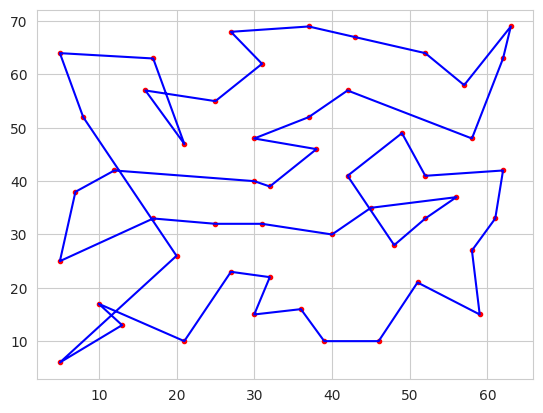

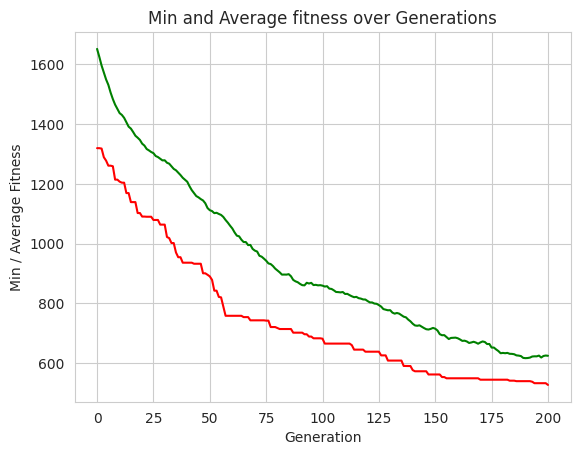

In [17]:

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = eaSimpleWithElitism(population, original, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()


gen	nevals	min               	avg               
0  	300   	1379.8216552734375	1659.1741943359375
1  	249   	1310.4322509765625	1556.9825439453125
2  	247   	1287.8658447265625	1484.140625       
3  	245   	1196.3240966796875	1426.6123046875   
4  	246   	1176.773681640625 	1378.2406005859375
5  	248   	1166.1844482421875	1327.76513671875  
6  	254   	1121.367919921875 	1276.0870361328125
7  	252   	1107.2823486328125	1242.1993408203125
8  	240   	1083.7982177734375	1215.25341796875  
9  	251   	1052.7469482421875	1185.69140625     
10 	255   	992.0347290039062 	1163.3614501953125
11 	246   	992.0347290039062 	1135.3466796875   
12 	256   	977.8543090820312 	1124.2110595703125
13 	240   	976.3033447265625 	1099.1490478515625
14 	248   	944.482666015625  	1075.930419921875 
15 	237   	925.3703002929688 	1052.3463134765625
16 	255   	917.2106323242188 	1024.9158935546875
17 	246   	873.9750366210938 	1004.0831298828125
18 	250   	873.9750366210938 	975.9058227539062 
19 	244   	827.14141

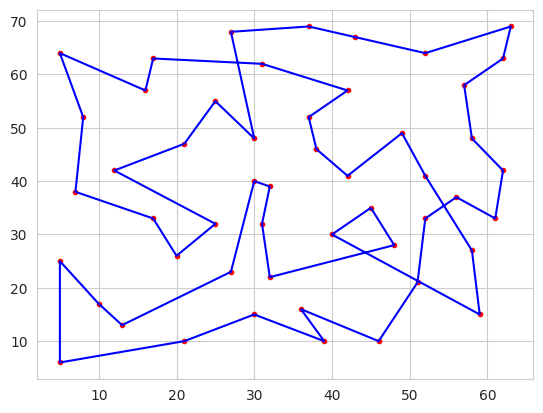

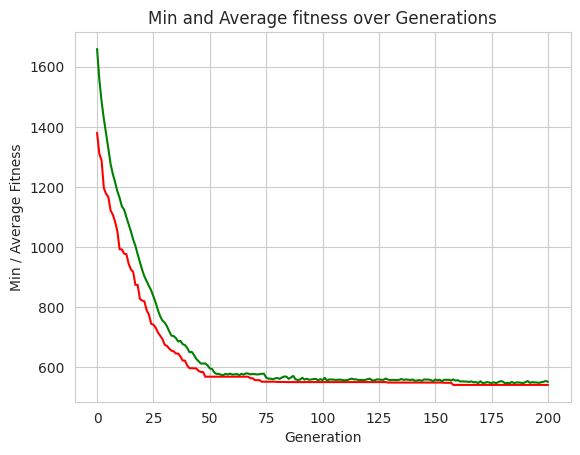

In [18]:
#improved version of selection function
population = original.population(n=POPULATION_SIZE)

original.register("select", original_select_function_improved, tournsize=6)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = eaSimpleWithElitism(population, original, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()

gen	nevals	min             	avg               
0  	300   	1432.53759765625	1664.2010498046875
1  	246   	1366.3441162109375	1572.303466796875 
2  	238   	1328.109619140625 	1508.4285888671875
3  	239   	1259.2978515625   	1442.7550048828125
4  	249   	1219.1275634765625	1407.0770263671875
5  	237   	1219.1275634765625	1354.6090087890625
6  	247   	1152.8292236328125	1319.8431396484375
7  	250   	1105.4105224609375	1293.4747314453125
8  	250   	1099.9146728515625	1264.3458251953125
9  	238   	1087.89111328125  	1229.4837646484375
10 	242   	1054.474609375    	1203.49560546875  
11 	247   	1024.4580078125   	1179.8822021484375
12 	245   	1011.163818359375 	1158.2269287109375
13 	250   	1001.883544921875 	1139.4407958984375
14 	239   	957.2152099609375 	1111.3189697265625
15 	240   	946.4243774414062 	1090.4210205078125
16 	242   	946.4243774414062 	1071.702392578125 
17 	241   	931.141357421875  	1062.0843505859375
18 	239   	929.1138305664062 	1050.100830078125 
19 	235   	894.033142089

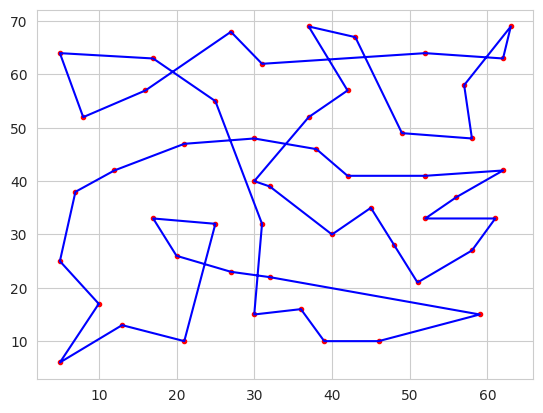

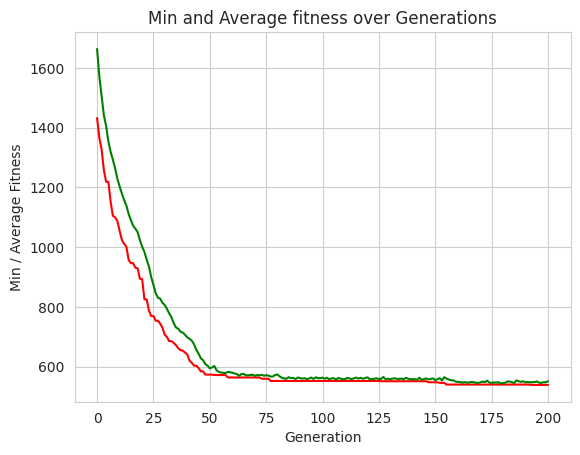

In [19]:
#improving the performance of GA

population = original.population(n=POPULATION_SIZE)

original.register("select", original_select_function_improved, tournsize=6)
original.register("mate", tools.cxOrdered)
original.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(tsp))

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = eaSimpleWithElitism(population, original, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

# print best individual info:
best = hof.items[0]
print("-- Best Ever Individual = ", best)
print("-- Best Ever Fitness = ", best.fitness.values[0])

# plot best solution:
plt.figure(1)
tsp.plotData(best)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()